In [1]:
import pandas as pd
import numpy as np
import timeit

from matplotlib import pyplot as plt
from matplotlib import rcParams
plt.style.use('ggplot')
rcParams['figure.figsize'] = (20.0, 10.0)
from matplotlib import colors

# import scipy.stats
from scipy.stats import mannwhitneyu
import math
from matplotlib.lines import Line2D

import plot
import calculate

In [2]:
#this defines the criterion which we use to filter authors
CAREER_LENGTH = 1
# this defines how long we follow each cohort
MAX_CAREER_LENGTH_COHORT = 15
END_YEAR = 2018

### Read authors with start and end year details

In [3]:
authorStartEndCareerData = pd.read_csv('./derived-data/authors-scientific-atleast-'+str(CAREER_LENGTH)+'-year-extended.csv')

In [4]:
print("authorStartEndCareerData: ", authorStartEndCareerData.shape[0])
# print(authorStartEndCareerData.head())

#print(authorStartEndCareerData[authorStartEndCareerData['author'] == 'donatella sciuto'])
authorStartEndCareerData.rename(columns={'num_pub':'total_num_pub'}, inplace=True)

authorStartEndCareerData:  1699352


In [5]:
authorStartEndCareerData.head()

,author,start_year,end_year,total_num_pub,career_length,max_absence,avg_absence,dropped_after_10,gender,early_career_qual,early_career_recognition,succ_after_15y,early_career_prod
0,'maseka lesaoana,2001,2015,2,15,14,7.5,True,none,23.0,5.0,23.0,1
1,(max) zong-ming cheng,2009,2011,2,3,13,7.5,True,none,4.0,4.0,4.0,2
2,(zhou) bryan bai,2011,2012,2,2,14,7.5,True,none,0.0,0.0,0.0,2
3,a aart blokhuis,1992,2005,2,14,13,7.5,True,none,0.0,0.0,0.0,1
4,a ahrabian,2017,2017,1,1,15,15.0,True,none,0.0,0.0,0.0,1


### Read Publication data

In [6]:
authorPublicationData = pd.read_csv('derived-data/author-publications-atleast-'+str(CAREER_LENGTH)+'-year.csv')
author_year_numPub = authorPublicationData.groupby(['author', 'year'])['pub_id'].count().reset_index()
author_year_numPub = author_year_numPub.rename(columns={'pub_id':'num_pub'})

print("authorPublicationData: ", authorPublicationData.shape[0])

authorPublicationData.head()

authorPublicationData:  9413377


,author,year,pub_id
0,graeme earl,2011,001c58d3-26ad-46b3-ab3a-c1e557d16821
1,gareth beale,2011,001c58d3-26ad-46b3-ab3a-c1e557d16821
2,m. nasser,2009,001c8744-73c4-4b04-9364-22d31a10dbf1
3,faisal zaman,2009,001c8744-73c4-4b04-9364-22d31a10dbf1
4,altaf hossain,2009,001c8744-73c4-4b04-9364-22d31a10dbf1


In [7]:
author_year_numPub.head()

,author,year,num_pub
0,'maseka lesaoana,2001,1
1,'maseka lesaoana,2015,1
2,(max) zong-ming cheng,2009,1
3,(max) zong-ming cheng,2011,1
4,(zhou) bryan bai,2011,1


In [8]:
authorPublicationData[authorPublicationData["author"] == "'maseka lesaoana"]

,author,year,pub_id
4543408,'maseka lesaoana,2015,2a10f544-51ac-4261-8a26-cf61c1abdc03
4896492,'maseka lesaoana,2001,4ff8ca7b-16b7-4bc8-b235-1eeac9b2aefa


## Publications analysis

In [9]:
author_year_numPub_sample = author_year_numPub#.head(10000)

In [10]:
author_year_numPub_with_authors = author_year_numPub_sample.merge(authorStartEndCareerData[['author','start_year', 'gender']], on="author")

groupByYearData = calculate.calculate_cumulative_for_authors(author_year_numPub_with_authors, 'num_pub')

In [50]:
years = groupByYearData['year'].unique()
years = sorted(years)

cohort_start_years = [y for y in years if y < (END_YEAR - MAX_CAREER_LENGTH_COHORT)]

num_years_in_cohort = 1

In [ ]:
# step = 3
# cohort_start_years = list(range(years[0], END_YEAR - MAX_CAREER_LENGTH_COHORT + step, step))
# skip_overlaping_years = False

In [ ]:
print(groupByYearData[groupByYearData['author'] == '\'maseka lesaoana'].head(10))
#print(groupByYearData[groupByYearData['author'] == 'donatella sciuto'].head(10))
print(groupByYearData[groupByYearData['author'] == '(max) zong-ming cheng'].head(10))

#### Tests

In [ ]:
cohort_careerage_df = plot.get_cohort_careerage_df(groupByYearData, cohort_start_years, MAX_CAREER_LENGTH_COHORT, "num_pub", authorStartEndCareerData)

#------------------------------------------
# some plausibility checks
print(cohort_careerage_df.head(n=1))
subset1 = cohort_careerage_df[(cohort_careerage_df.cohort_start_year == 1991) & (cohort_careerage_df.career_age == 1) & 
                              (cohort_careerage_df.gender == "all")]
vals1 = subset1["values"]

subset10 = cohort_careerage_df[(cohort_careerage_df.cohort_start_year == 1991) & (cohort_careerage_df.career_age == 10) & 
                               (cohort_careerage_df.gender == "all")]
vals10 = subset10["values"]

from collections import Counter

print(type(vals1))
print(Counter(vals1.values[0]))
print(len(vals1.values[0]))


print(type(vals10))
print(Counter(vals10.values[0]))
print(len(vals10.values[0]))


In [ ]:
groupByYearData[groupByYearData['year'] == 2018].shape

In [ ]:
groupByYearData[groupByYearData['year'] == 2018]['num_pub'].sum()

## Run cohort analysis

In [67]:
from importlib import reload
reload(plot)
reload(calculate)

<module 'calculate' from '/home/danielkostic/cumulative-advantage/calculate.py'>

In [65]:
from plot import *

max_career_age_cohort, criterion, criterion_display = MAX_CAREER_LENGTH_COHORT, "num_pub", "Publications"

In [53]:
print("get_cohort_careerage_df")
cohort_careerage_df = get_cohort_careerage_df(groupByYearData, cohort_start_years, max_career_age_cohort, criterion, authorStartEndCareerData)

get_cohort_careerage_df


In [54]:
print("group_cohorts")
cohort_careerage_df = group_cohorts(cohort_careerage_df, cohort_start_years, num_years_in_cohort)

group_cohorts


In [55]:
#gini
cohort_size_gini = get_cohort_size_gini(cohort_careerage_df,criterion, cohort_careerage_df["cohort_start_year"].unique())

plot_gini


/home/danielkostic/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/danielkostic/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:2022: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


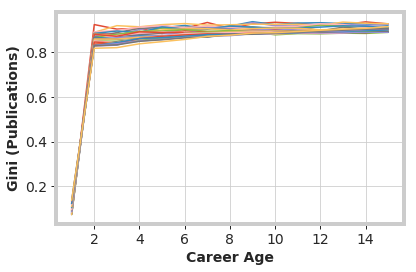

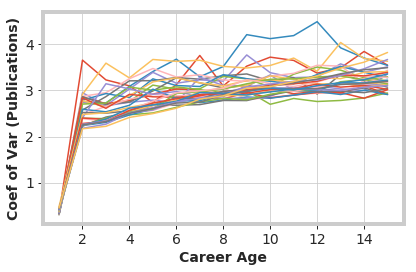

In [56]:
print("plot_gini")
plot_gini(cohort_size_gini, criterion, criterion_display)

plot_cohort_size_gini_cor
unique_career_ages:
[ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15.]


/home/danielkostic/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "
/home/danielkostic/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/danielkostic/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:2022: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


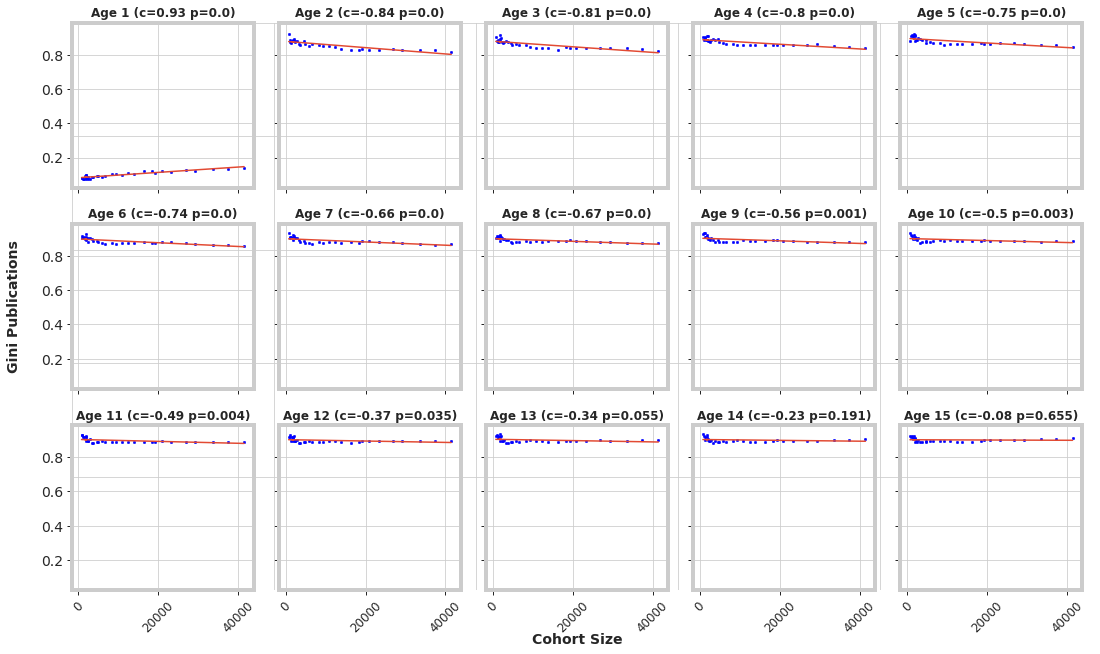

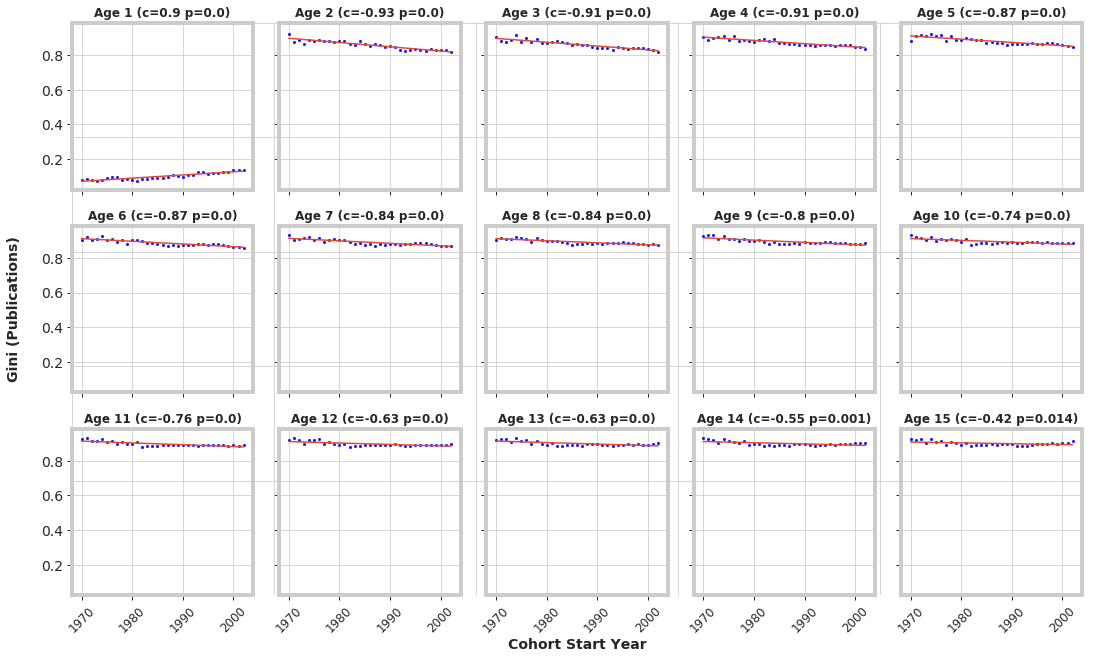

In [66]:
print("plot_cohort_size_gini_cor")
plot_cohort_size_gini_cor(cohort_size_gini,  criterion, criterion_display)

plot_cohort_means_over_ages


/home/danielkostic/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/danielkostic/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:2022: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


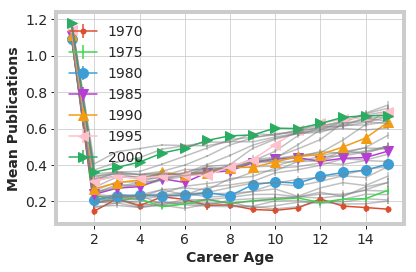

In [58]:
# effect size and significance - mwu
cohort_effect_size_df = get_cohort_effect_size(cohort_careerage_df)

# mean/std/median
stats = get_cohort_stats(cohort_careerage_df, criterion)
stats = stats.merge(cohort_effect_size_df, on=['cohort_start_year', 'career_age'])
# doesnt plot anything
#     plot_cohort_gender_diffs(stats, criterion, criterion_display)
print("plot_cohort_means_over_ages")
plot_cohort_means_over_ages(stats, criterion, criterion_display)

In [63]:
stats[['cohort_start_year', 'cohort_size', 'career_age', 'cliffd_m_f', 'values', 'effect', 'statistic', 'pvalue']].head()

,cohort_start_year,cohort_size,career_age,cliffd_m_f,values,effect,statistic,pvalue
0,1970,763,1,0.001992,"([1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 3.0, 1.0, 1.0,...",0.000922,7265.5,0.963317
1,1970,763,2,0.002060,"([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 6.0, 0.0, 0.0,...",0.000954,7265.0,0.968310
2,1970,763,3,-0.070742,"([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 9.0, 0.0, 1.0,...",0.032746,7795.0,0.235314
3,1970,763,4,0.072734,"([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.033668,6750.5,0.208422
4,1970,763,5,-0.005495,"([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.0, 0.0, 0.0,...",0.002543,7320.0,0.930304


/home/danielkostic/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/danielkostic/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:2022: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


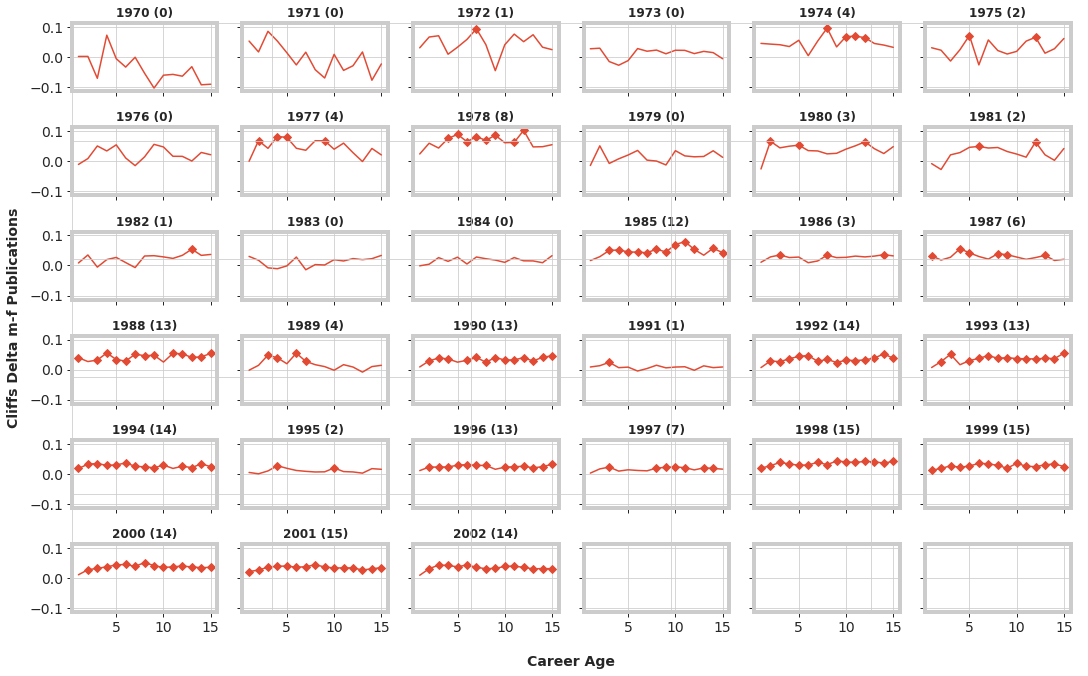

In [59]:
plot_cohort_diffs_over_ages(stats, criterion, criterion_display)

get_cohort_careerage_df
plot_gini


/home/danielkostic/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/danielkostic/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:2022: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


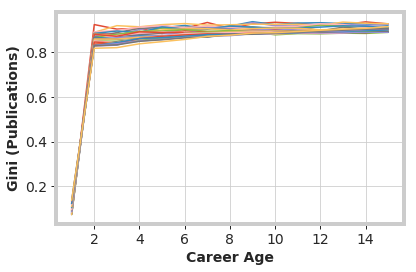

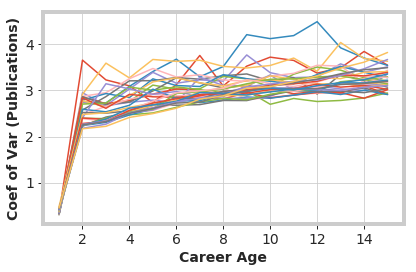

plot_cohort_size_gini_cor
unique_career_ages:
[ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15.]


/home/danielkostic/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


plot_cohort_means_over_ages


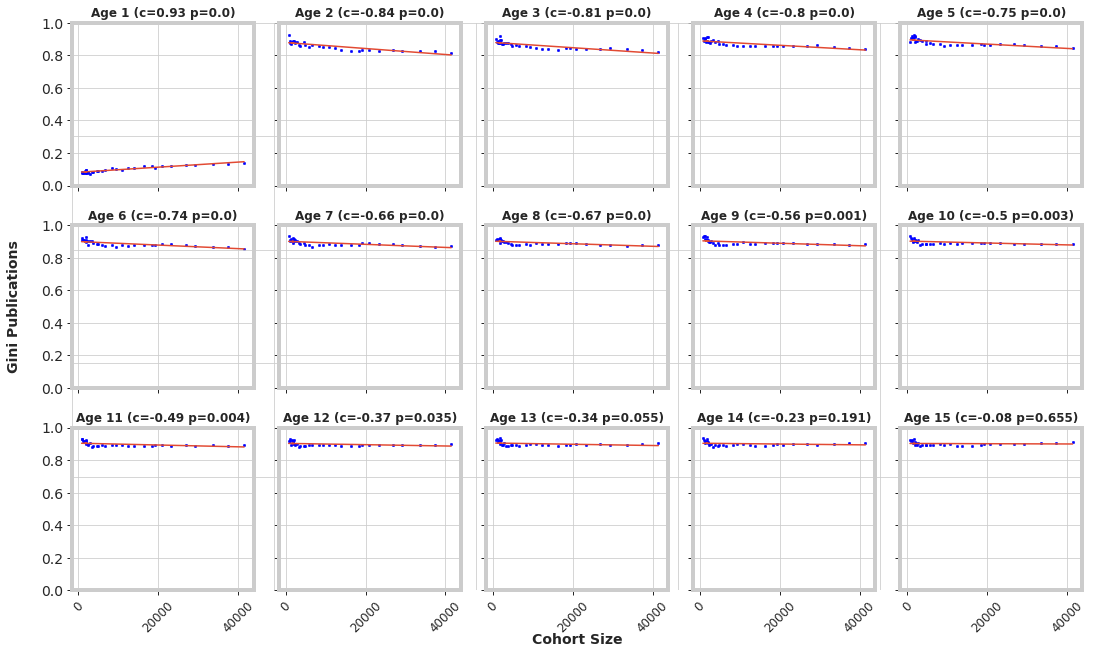

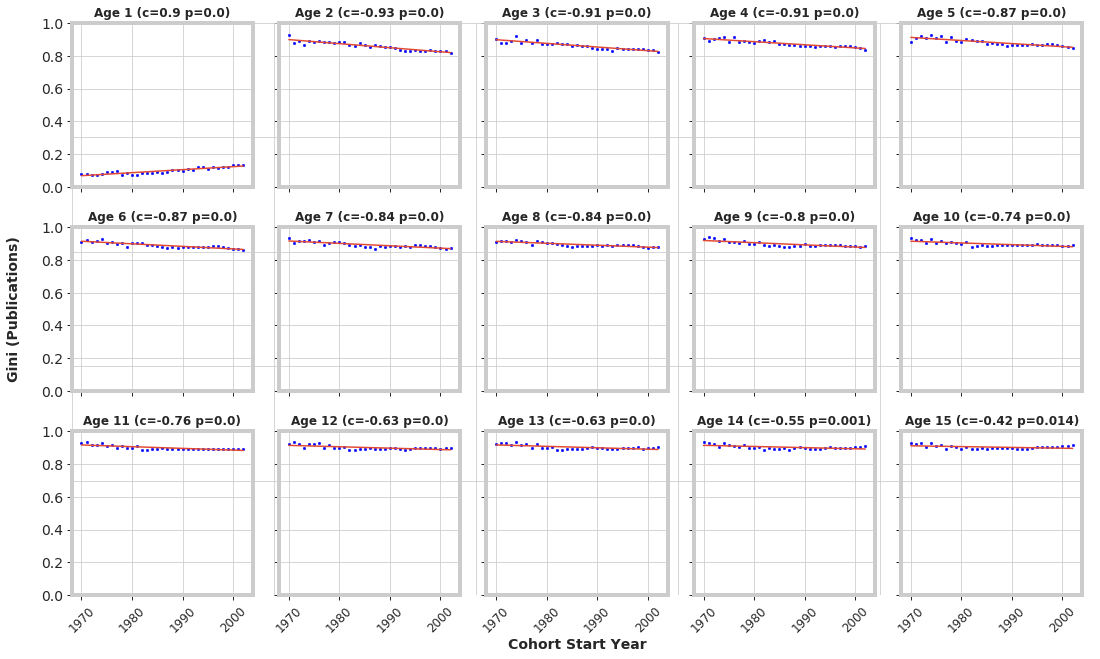

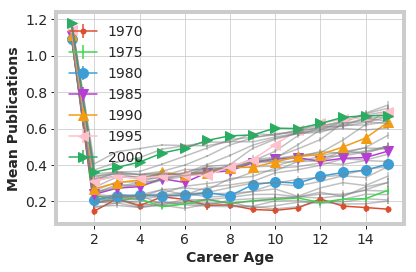

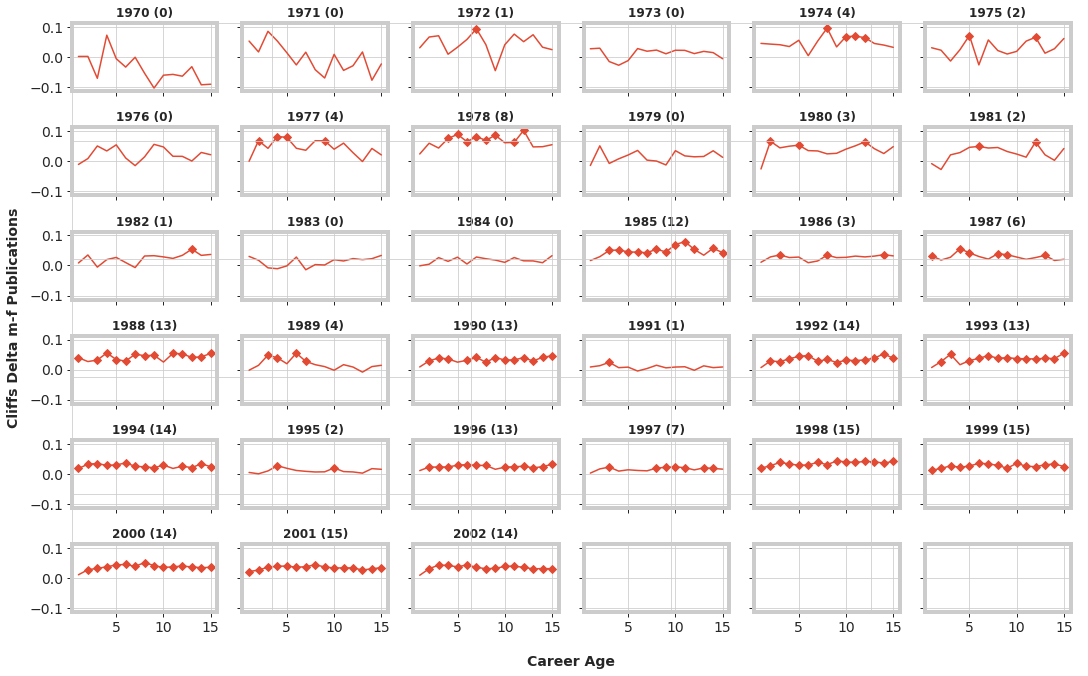

In [68]:
plot.run_cohort_analysis(groupByYearData, cohort_start_years, MAX_CAREER_LENGTH_COHORT, "num_pub", "Publications", authorStartEndCareerData, num_years_in_cohort)  

get_cohort_careerage_df
plot_gini


/home/danielkostic/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/danielkostic/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:2022: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


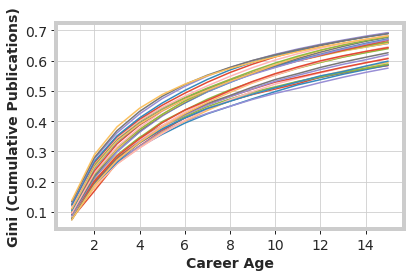

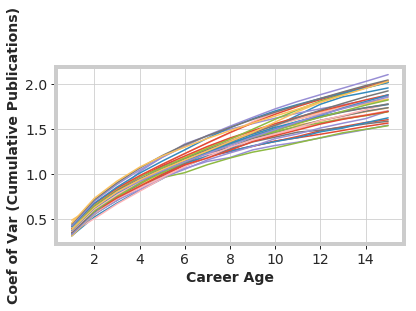

plot_cohort_size_gini_cor
unique_career_ages:
[ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15.]


/home/danielkostic/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


plot_cohort_means_over_ages


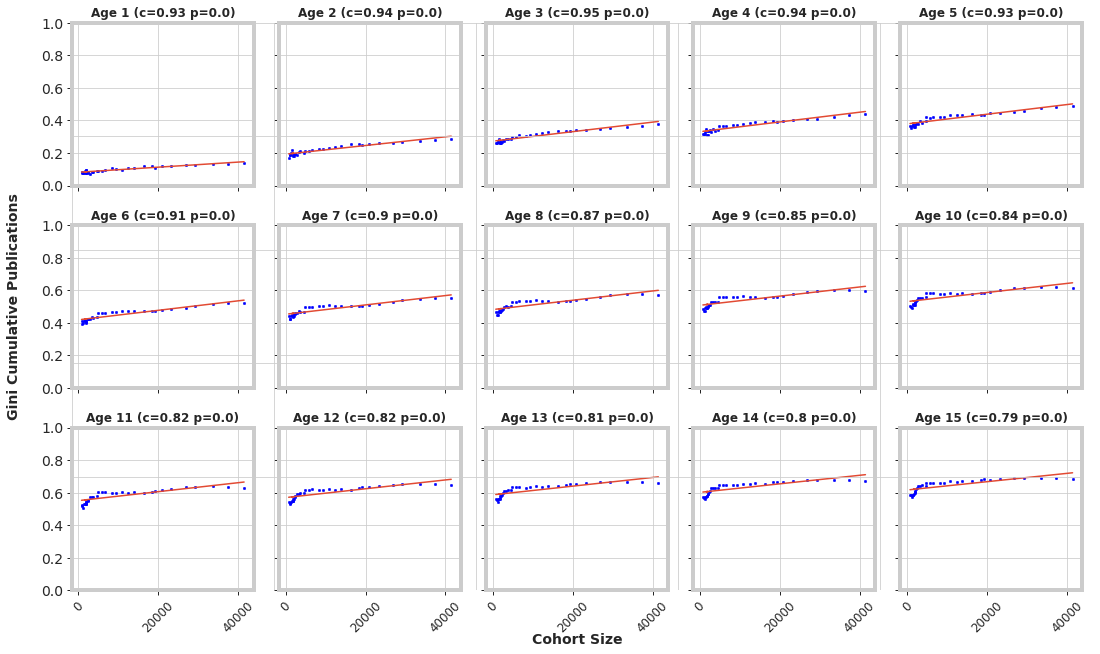

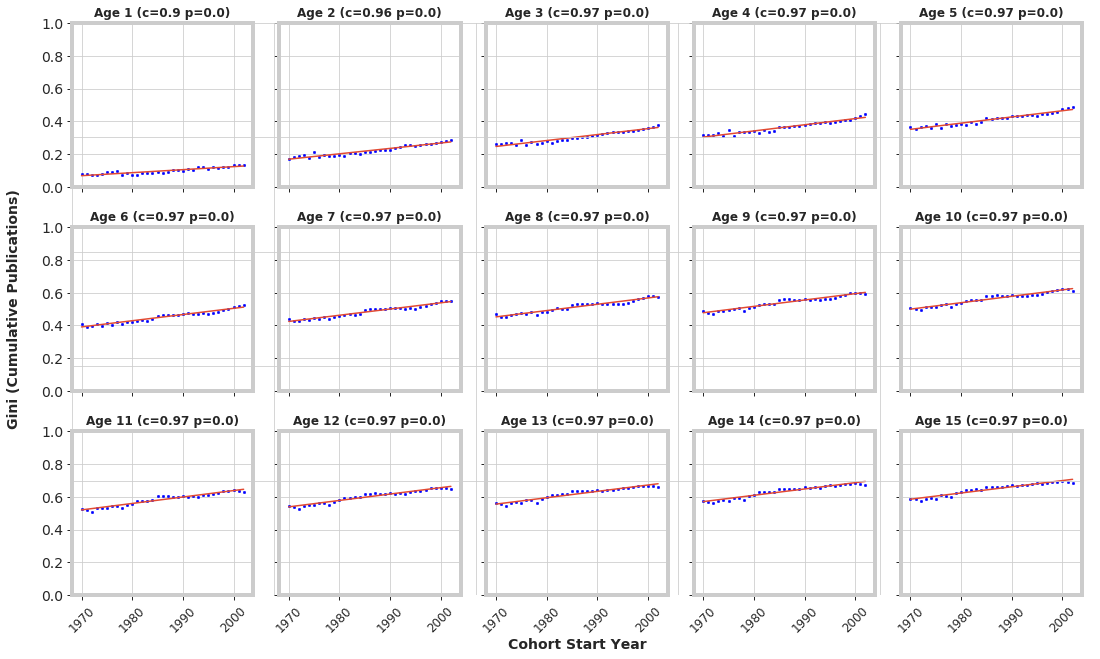

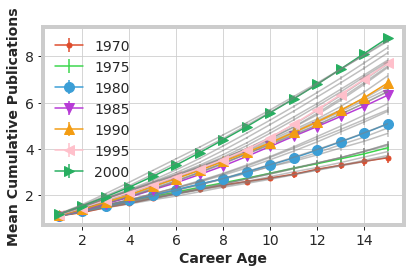

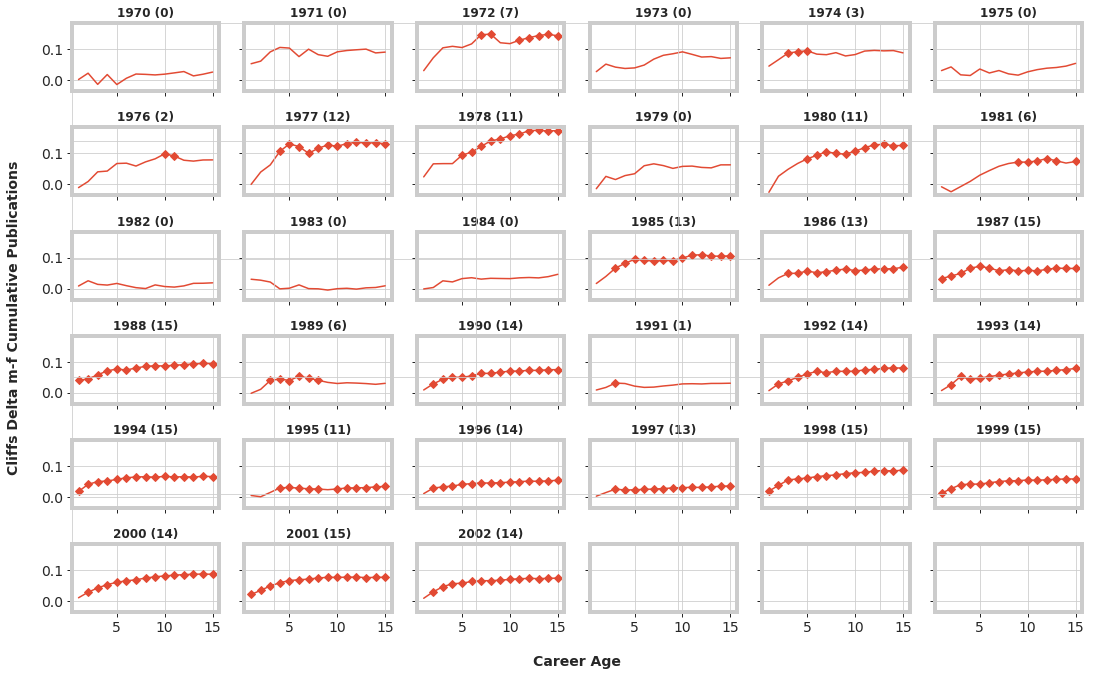

In [69]:
plot.run_cohort_analysis(groupByYearData, cohort_start_years, MAX_CAREER_LENGTH_COHORT, "cum_num_pub", "Cumulative Publications", authorStartEndCareerData, num_years_in_cohort)  